# Agent Birth Rate Calibration and Beyond

The aim of this notebook is to 

## Imports

Import all of the necessary packages, including the `StationSim` model:

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sys import path
import time
from tqdm import tqdm

%matplotlib inline

In [2]:
path.append('../src/model/')
from stationsim_gcs import Model

## Paths and Directories

Define some paths to and from data:

In [3]:
combined_frames_path = '../data/outputs/combined_frames.csv'

In [4]:
output_data_dir = '../data/outputs/'

## Functions

Here, I have defined some functions that will be useful later in the analysis:

In [5]:
def get_number_pedestrians_in_frame(df, frame):
    tdf = df.loc[df['frame']==frame, :]
    return len(tdf['pedestrianID'].unique())

In [6]:
def __get_error(observed, model, variable):
    return observed[variable] - model[variable]

In [7]:
def get_error(observed_results, model_results):
    n_max_peds = __get_error(observed_results, model_results, 'n_max_active_pop')
    t_max_peds = __get_error(observed_results, model_results, 't_max_active_pop')
    t_max = __get_error(observed_results, model_results, 't_max')
    
    results = {'n_max_active_pop': n_max_peds,
               't_max_active_pop': t_max_peds,
               't_max': t_max,
               'rate': model_results['rate']}
    return results

## Analysis

We start our analysis by reading in the data pertaining to the paths of pedestrians across the concourse:

In [28]:
data = pd.read_csv(combined_frames_path)
data.head()

,frame,pedestrianID,x,y
0,4506,245,456.903221,507.182260
1,4506,246,447.735569,490.672126
2,4506,247,466.788192,520.933037
3,4506,248,475.195786,527.601525
4,4506,249,281.777398,518.092819


As we saw in the previous notebook, this dataset is made up fo observations pertaining to 4 columns:
* `frame`, i.e. the frame in which the observation was captured,
* `pedestrianID` i.e. the unique pedestrian that the observation relates to,
* `x`, i.e. the $x$-coordinate of the pedestrian within the concourse in the frame,
* `y`, i.e. the $y$-coordinate of the pedestrian within the concourse in the frame.

### Exploring the variation in number of pedestrian in the system over time

In [9]:
frame_numbers = data['frame'].unique()
pedestrians_per_frame = list()

for frame_number in frame_numbers:
    d = {'frame': frame_number,
         'n_pedestrians': get_number_pedestrians_in_frame(data, frame_number)}
    pedestrians_per_frame.append(d)
    
pedestrians_per_frame = pd.DataFrame(pedestrians_per_frame)

Plot how the number of pedestrians in the system varies frame by frame:

In [10]:
# Insert code here


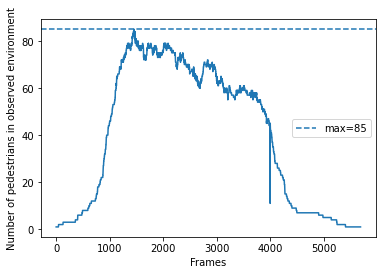

In [11]:
plt.figure()
sns.lineplot(x='frame', y='n_pedestrians', data=pedestrians_per_frame)
plt.axhline(85, linestyle='--', label='max=85')
plt.xlabel('Frames')
plt.ylabel('Number of pedestrians in observed environment')
plt.legend()
plt.show()

From the above data and visualisation, can we work out what the maximum number of pedetrians is in the system at any given time?

In [12]:
# Insert code here


In [13]:
# Maximum number of pedestrians in the system at any one time
max_n_peds = max(pedestrians_per_frame['n_pedestrians'])
max_n_peds

85

From the above data and visualisation, can we work out when the system contains this maximum number of pedetrians?

In [14]:
# Insert code here


In [15]:
# Time at which the maximum number of pedestrians in the sytem occurs
max_peds_frames = pedestrians_per_frame.loc[pedestrians_per_frame['n_pedestrians']==max_n_peds, 'frame']
t_max_n_peds = np.mean(max_peds_frames)
t_max_n_peds

1454.0

From the above data and visualisation, can we work out how many frames it takes all of the pedestrians to complete their journeys across the concourse?

In [16]:
# Insert code here


In [17]:
# Time at which all pedestrians have completed their trajectories
end_frame = max(pedestrians_per_frame['frame'])
end_frame

5687

### Comparing data with the model

Create a dictionary of model parameters (as in [the previous notebook on running models](./1_running_models.ipynb)) with the following parameter values:

* `station`: `Grand_Central`
* `step_limit`: 20000
* `do_print`: `False`
* `pop_total` number of pedestrians found in previous notebook
* `speed_mean`: value found in previous notebook
* `speed_std`: value found in previous notebook
* `speed_min`: value found in previous notebook

In [18]:
# Insert code here
# Replace None with a dictionary of parameter values
model_params = None

In [19]:
scaling_factor = 25/14

In [20]:
speed = {'mean': 1.6026400144010877 / scaling_factor,
         'std': 0.6642343305178546 / scaling_factor,
         'min': 0.31125359137714953 / scaling_factor}

In [21]:
model_params = {'station': 'Grand_Central',
                'speed_mean': speed['mean'],
                'speed_std:': speed['std'],
                'speed_min': speed['min'],
                'step_limit': 20000,
                'do_print': False,
                'pop_total': 274}

The parameter that we want to find the value for in this notebook is `birth_rate` - let's try running the model with a birth rate of $1.0$:

WARNING, RUNNING THE MODEL WITH THIS NUMBER OF PEDESTRIAN MAY TAKE A COUPLE OF MINUTES

In [22]:
# Insert code here
# Replace None with the birth rate for which you would like to run the model
birth_rate = None
birth_rate = 1.0

# Set birth rate value
model_params['birth_rate'] = birth_rate

# Create model based on model parameters
model = Model(**model_params)

../src/model/stationsim_gcs.py:596: RuntimeWarning: speed_std: is not a model parameter.
  warnings.warn(f'{key} is not a model parameter.',


In [23]:
# Create an empty list in which to collect results
population_results = list()

n_max_active_pop = 0
t_max_active_pop = 0
t_max = False

# Iterate the model forward
for _ in tqdm(range(model.step_limit)):
    model.step()
    timestep_results = {'frame': model.step_id,
                        'active_pedestrians': model.pop_active}
    population_results.append(timestep_results)

    # Update max_active_pop
    if model.pop_active > n_max_active_pop:
        n_max_active_pop = model.pop_active
        t_max_active_pop = model.step_id

    # get t_max
    if not t_max and model.step_id > 1000 and model.pop_active == 1:
        t_max = model.step_id

model_metrics = {'n_max_active_pop': n_max_active_pop,
                 't_max_active_pop': t_max_active_pop,
                 't_max': t_max,
                 'rate': birth_rate}

100%|██████████| 20000/20000 [02:18<00:00, 144.72it/s]


In [24]:
# Convert list of population results into a Pandas dataframe
population_results = pd.DataFrame(population_results)

Now that the model has run, let us have a look at the model metrics that have been produced:

In [25]:
model_metrics

{'n_max_active_pop': 63, 't_max_active_pop': 6201, 't_max': 9985, 'rate': 1.0}

How do these compare to what we observe in the data? Considering discussing this with your group. Note that you will each have different results, but will hopefull observe the same qualitative differences between your results and the observational data. Why should each of your results be different? If unsure, discuss with Natacha or Keiran

(INSERT OBSERVATIONS HERE)

We can also plot the variation in the number of active pedestrian agents in the system over time, and compare this to how the number of pedestrians in the concourse varies over time in the data:

In [26]:
# Insert code here


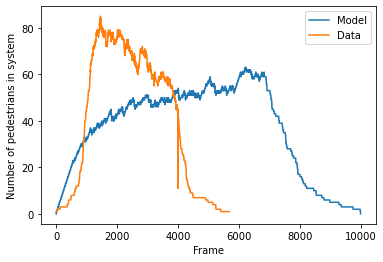

In [27]:
plt.figure()
sns.lineplot(x='frame', y='active_pedestrians', data=population_results, label='Model')
sns.lineplot(x='frame', y='n_pedestrians', data=pedestrians_per_frame, label='Data')
plt.xlabel('Frame')
plt.ylabel('Number of pedestrians in system')
plt.legend()
plt.show()

What can we learn from this plot about the behaviour of the model in comparison to the observed data?

(INSERT OBSERVATIONS HERE)

### Exploration

At this stage, we can hopefully agree that, when using a `birth_rate` of $1.0$, the model does not behave in a manner that reflects what we observe in the data.
If we compare our results with those of our neighbours, we may also observe that there is some variability between different model runs.
This leads us on to the final section of the practicals - an open-ended exploration of the model in comparison to the observational data.
Some ideas that you could consider for your investigation might be
* Finding the correct value of `birth_rate`:
    * Running the model for different birth rates, and comparing results via visualisations
    * Running the model for different birth rates, and comparing results via numerical metrics
* Exploring variability in the model:
    * Running the model multiple times for the same birth rates to explore how the model visualisations vary between runs
    * Running the model multiple times for the same birth rates to explore how the numerical model metrics vary between runs
* Exploring the qualitative behaviour of the model:
    * Producing animations of the observed data and animations of the model for different birth rates to explore how the behaviours compare

You are, however, very welcome to take your investigations in different directions.
If you have an idea, but are unsure about it then feel free to run it by Natacha or Keiran.

In [ ]:
# Insert code here
